In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread
import numpy as np

cle.select_device("RTX")

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [2]:
raw = cle.push(imread("C:/structure/data/netosis_deskew/netosis_ch2.tif")[:,:,0:500])

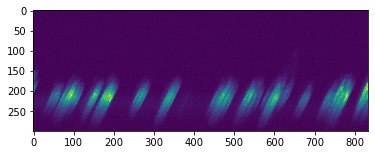

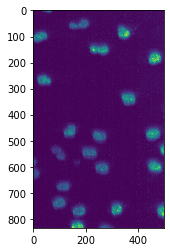

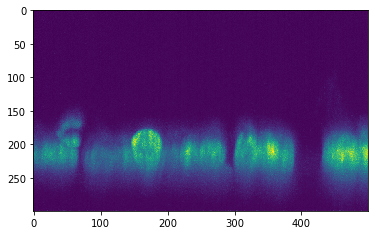

In [3]:

cle.imshow(cle.maximum_x_projection(raw))
cle.imshow(cle.maximum_y_projection(raw))
cle.imshow(cle.maximum_z_projection(raw))

(834, 300, 500)
[[-2.45962156e-05 -5.00000000e-01  0.00000000e+00  3.25006149e+02]
 [ 2.00004260e+00  8.66025404e-01  0.00000000e+00 -4.79914461e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


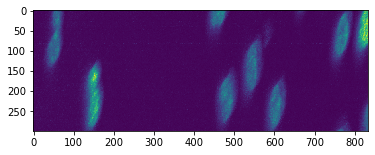

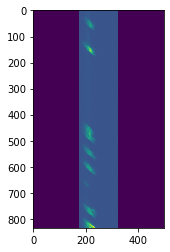

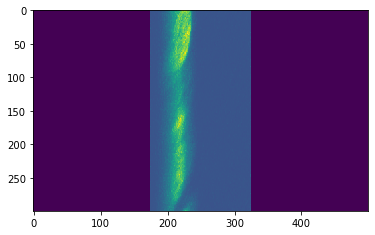

In [4]:
at = cle.AffineTransform3D()
print(raw.shape)
at.center(raw.shape)

# shearing
deskew_factor = 1.7321
shear_mat = np.array([
                    [1.0, 0 ,0 , 0],
                    [deskew_factor, 1.0, 0.0, 0],
                    [0, 0.0, 1.0, 0],  
                    [0.0, 0.0, 0.0, 1.0]          
                    ])   
at._concatenate(shear_mat)

# rotate
at.rotate(angle_in_degrees=30, axis=2)

at.center(raw.shape, undo=True)
transformed = cle.affine_transform(raw, transform=at)
print(at._matrix)

cle.imshow(cle.maximum_x_projection(transformed))
cle.imshow(cle.maximum_y_projection(transformed))
cle.imshow(cle.maximum_z_projection(transformed))

In [5]:
import stackview

stackview.orthogonal(transformed, continuous_update=True)

In [ ]:
import napari
viewer = napari.Viewer()

viewer.add_image(raw)
viewer.add_image(transformed)